In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-traffic-accidents/RTA Dataset.csv
/kaggle/input/road-traffic-accidents/cleaned.csv
/kaggle/input/ukdataset-use-ridge-csv/ridge.csv


In [2]:
df = pd.read_csv('/kaggle/input/road-traffic-accidents/RTA Dataset.csv')
df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [3]:
df.shape

(12316, 32)

In [4]:
df.isnull().sum()


Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

In [5]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        
#Categorical Columns: Mode Imputation
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipykernel_13/2351811842.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [6]:
from sklearn.preprocessing import LabelEncoder

# Label encoding for categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.shape

(12316, 32)

In [7]:

# Selected features and target
selected_features = ['Time', 'Number_of_casualties', 'Number_of_vehicles_involved',
                     'Light_conditions', 'Age_band_of_casualty', 'Type_of_collision',
                     'Age_band_of_driver', 'Road_surface_type', 'Vehicle_driver_relation',
                     'Driving_experience', 'Area_accident_occured', 'Lanes_or_Medians',
                     'Casualty_class', 'Cause_of_accident', 'Types_of_Junction',
                     'Vehicle_movement']
target_column = 'Accident_severity'



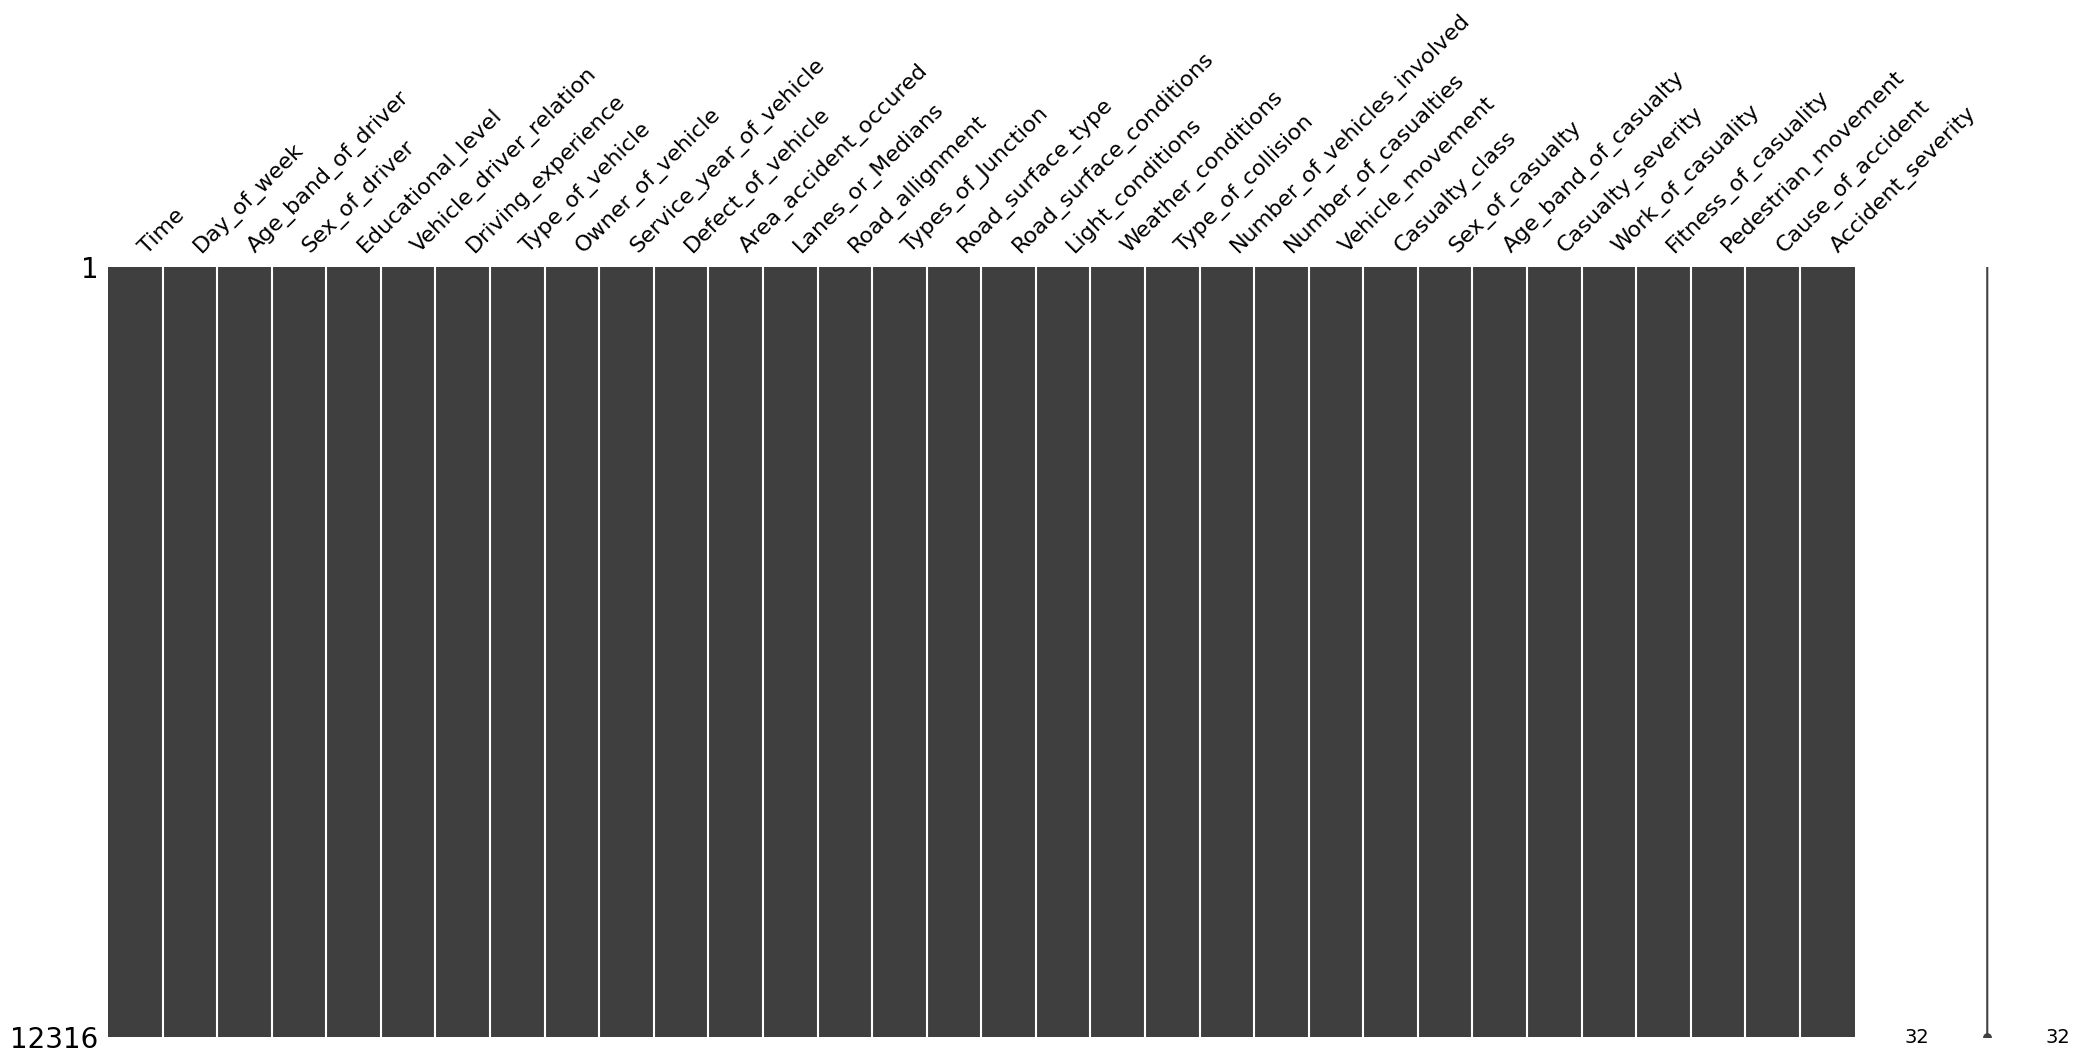

In [8]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df)
plt.show()


100%|===================| 7391/7392 [01:24<00:00]       The figure layout has changed to tight


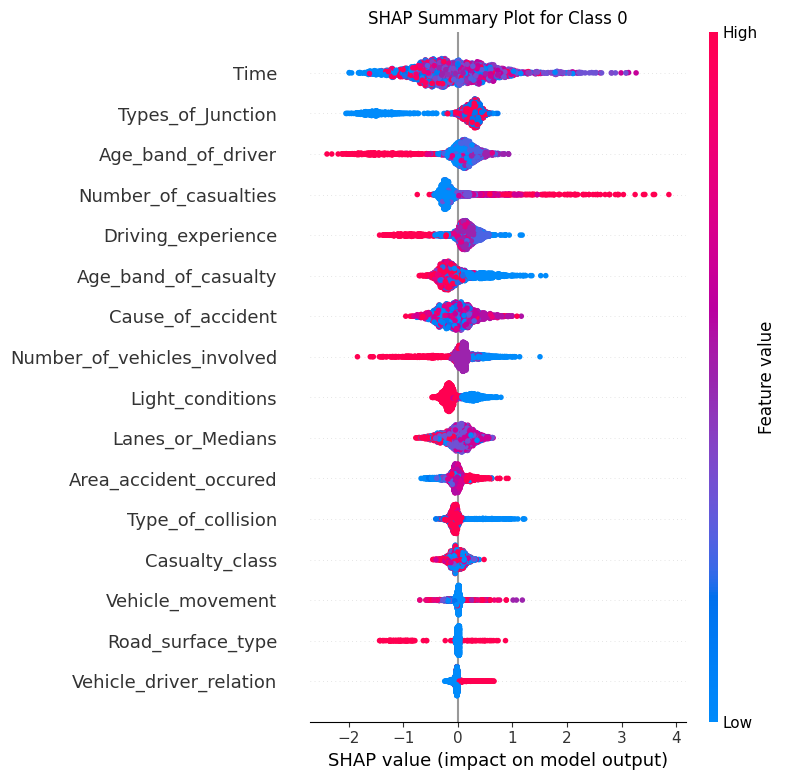

The figure layout has changed to tight


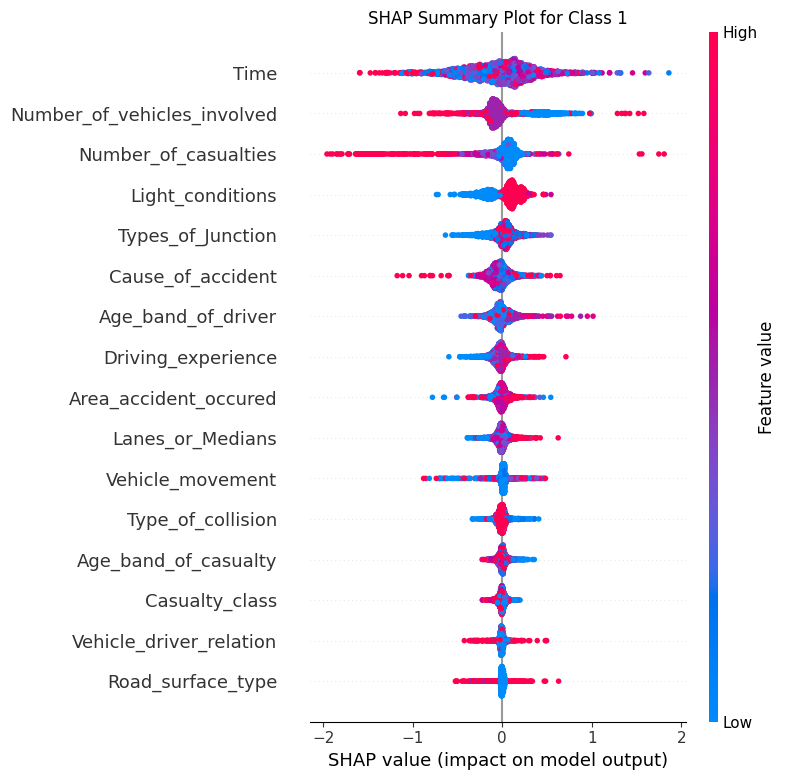

The figure layout has changed to tight


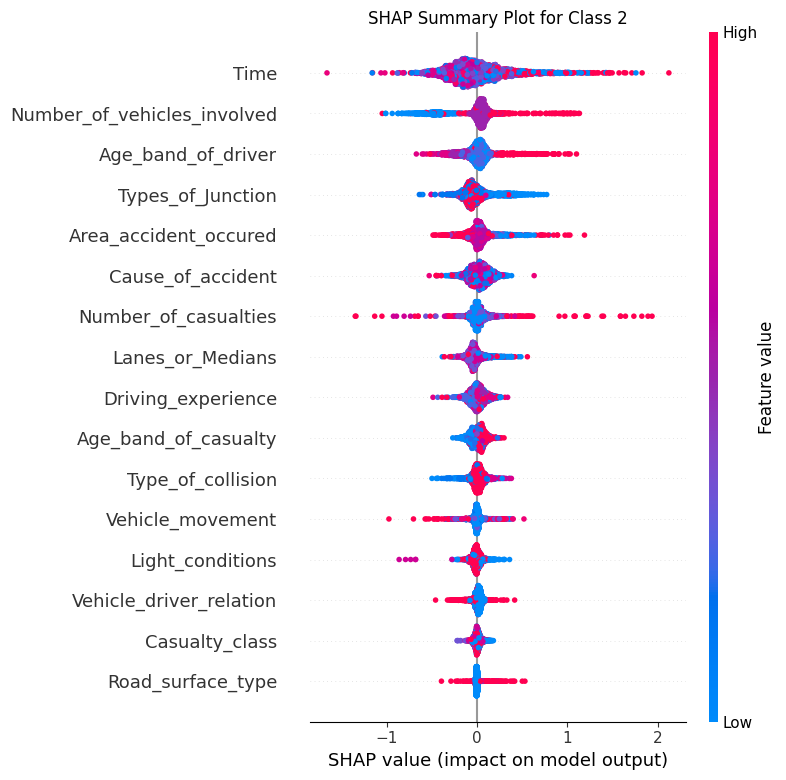

In [9]:
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Define features and target
X = df[selected_features]
y = df[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# SHAP explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary for each class using legacy API to allow plt.title
for class_index in range(shap_values.values.shape[2]):
    shap.summary_plot(
        shap_values.values[:, :, class_index],  # SHAP values for this class
        X_test,                                 # Data used
        feature_names=shap_values.feature_names,
        plot_type="dot",                        # Beeswarm plot
        show=False                              # Don't display yet
    )
    plt.title(f"SHAP Summary Plot for Class {class_index}")  # Add title manually
    plt.tight_layout()
    plt.show()


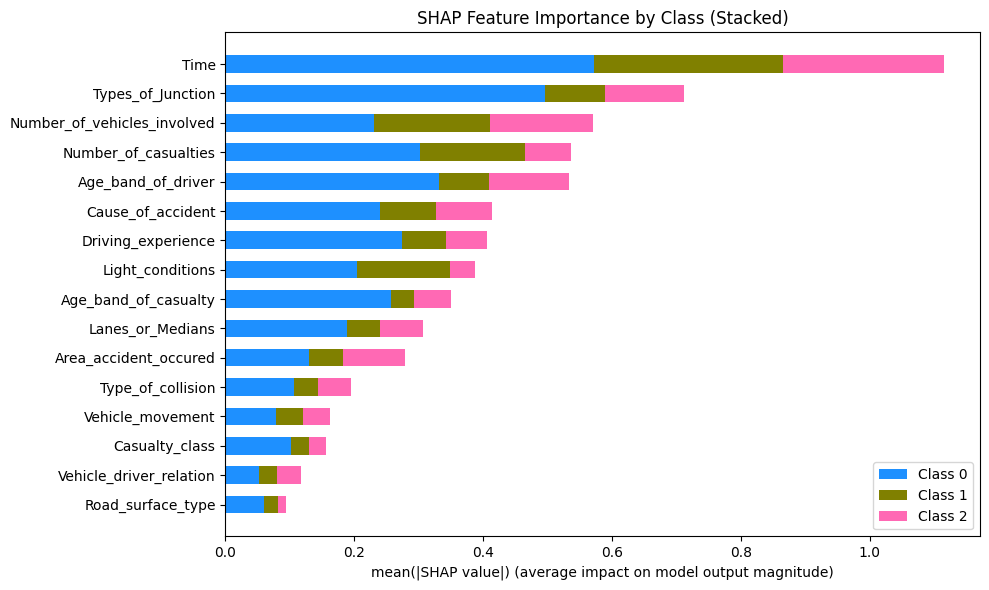

In [10]:

# Extract SHAP values per class
shap_array = shap_values.values  # shape: (n_samples, n_features, n_classes)
feature_names = shap_values.feature_names
num_classes = shap_array.shape[2]

# Calculate mean(|SHAP|) for each class & feature
mean_shap = np.abs(shap_array).mean(axis=0)  # shape: (n_features, n_classes)

# Sort features by total importance (sum over all classes)
total_shap = mean_shap.sum(axis=1)
sorted_idx = np.argsort(total_shap)[::-1]

# Top N features
top_n = 16
top_idx = sorted_idx[:top_n]
top_features = [feature_names[i] for i in top_idx]

# Plot
colors = ['dodgerblue', 'olive', 'hotpink']
class_labels = ['Class 0', 'Class 1', 'Class 2']

fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(top_n)
for class_i in range(num_classes):
    values = mean_shap[top_idx, class_i]
    ax.barh(range(top_n), values, left=bottom, height=0.6, label=class_labels[class_i], color=colors[class_i])
    bottom += values

ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features)
ax.invert_yaxis()
ax.set_xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
ax.set_title("SHAP Feature Importance by Class (Stacked)")
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


100%|===================| 5730/5757 [01:05<00:00]       


 SHAP Summary Plot (Beeswarm) for Class 0


The figure layout has changed to tight


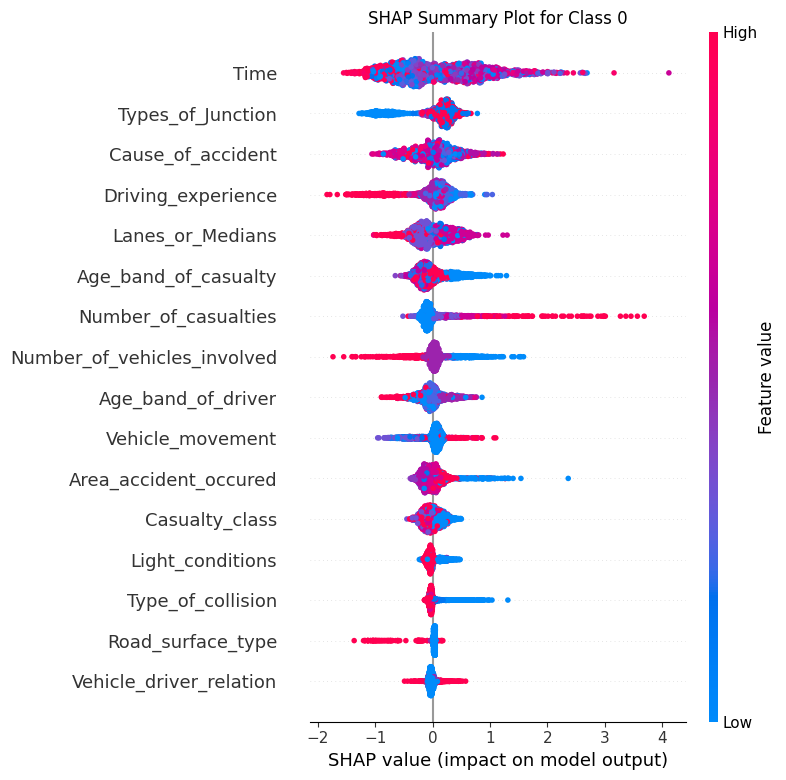


 SHAP Summary Plot (Beeswarm) for Class 1


The figure layout has changed to tight


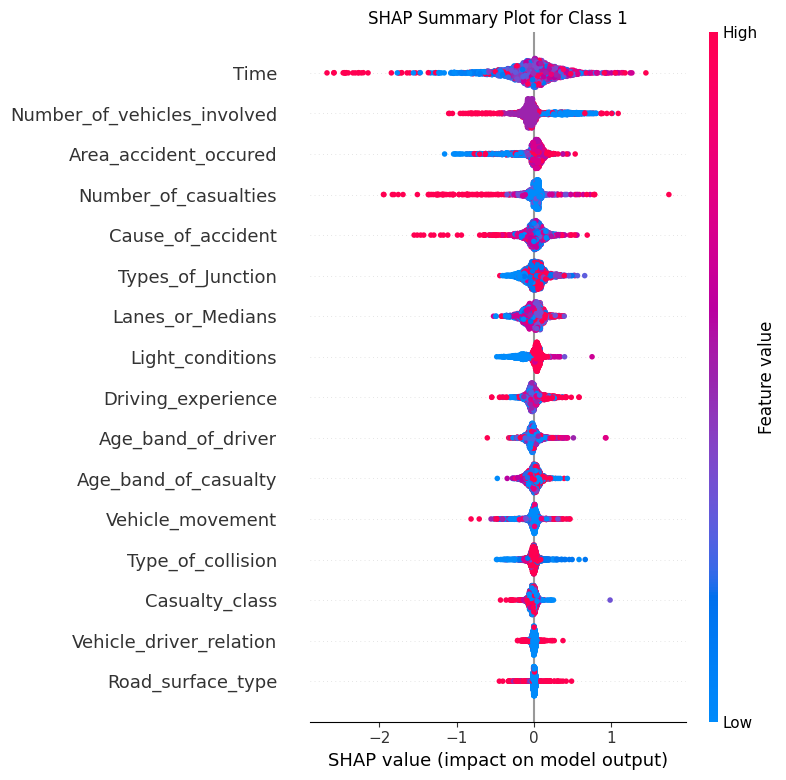


 SHAP Summary Plot (Beeswarm) for Class 2


The figure layout has changed to tight


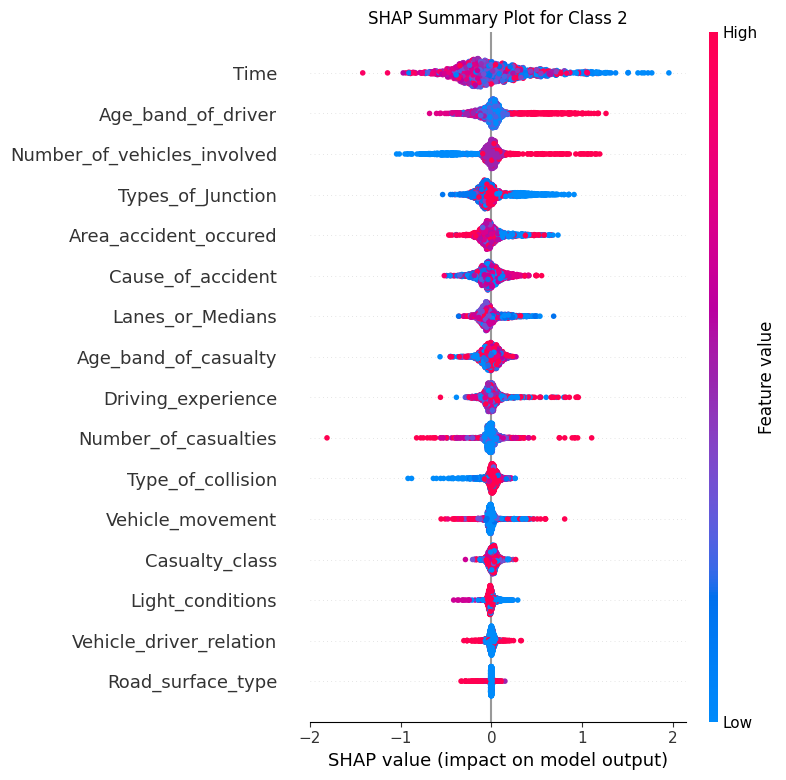

In [11]:



# Load dataset
df = pd.read_csv('/kaggle/input/road-traffic-accidents/RTA Dataset.csv')

# Selected features and target
selected_features = ['Time', 'Number_of_casualties', 'Number_of_vehicles_involved',
                     'Light_conditions', 'Age_band_of_casualty', 'Type_of_collision',
                     'Age_band_of_driver', 'Road_surface_type', 'Vehicle_driver_relation',
                     'Driving_experience', 'Area_accident_occured', 'Lanes_or_Medians',
                     'Casualty_class', 'Cause_of_accident', 'Types_of_Junction',
                     'Vehicle_movement']
target_column = 'Accident_severity'

# Drop missing values
df = df[selected_features + [target_column]].dropna()

# Encode categorical features
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col].astype(str))

# Define features and target
X = df[selected_features]
y = df[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# SHAP explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Number of classes
num_classes = shap_values.values.shape[2]

# Plot SHAP summary for each class
for class_index in range(num_classes):
    class_shap = shap.Explanation(
        values=shap_values.values[:, :, class_index],
        base_values=shap_values.base_values[:, class_index],
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )

    print(f"\n SHAP Summary Plot (Beeswarm) for Class {class_index}")
    shap.summary_plot(
        class_shap.values,
        X_test,
        feature_names=class_shap.feature_names,
        plot_type="dot",   # or "bar"
        show=False
    )
    plt.title(f"SHAP Summary Plot for Class {class_index}")
    plt.tight_layout()
    plt.show()


# Applying LIME

In [12]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [13]:
from lime.lime_tabular import LimeTabularExplainer

# LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=selected_features,
    class_names=[str(cls) for cls in sorted(y.unique())],
    mode='classification'
)

# Choose one test sample to explain
sample_idx = 16 # You can try different values
sample = X_test.iloc[sample_idx].values.reshape(1, -1)

# Explain the prediction for the selected instance
exp = explainer.explain_instance(
    data_row=sample.flatten(),
    predict_fn=model.predict_proba
)

# Show explanation
print(f"\n LIME Explanation for Test Sample #{sample_idx}")
exp.show_in_notebook(show_table=True, show_all=False)


 LIME Explanation for Test Sample #16


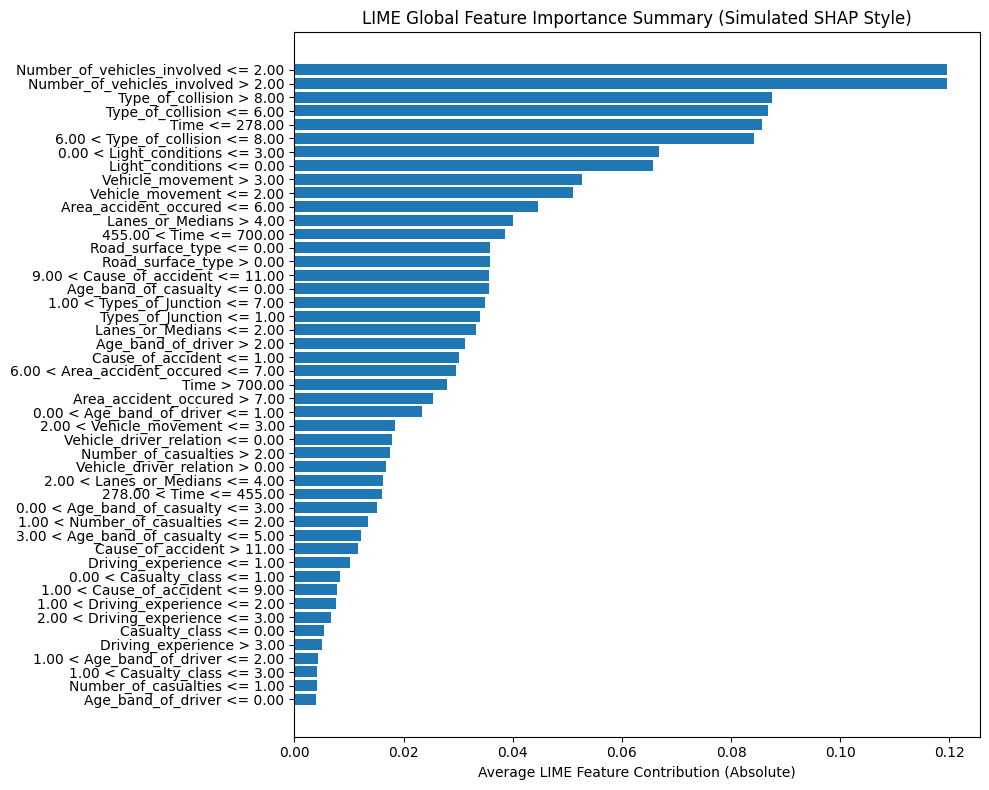

In [14]:
from lime.lime_tabular import LimeTabularExplainer
from collections import defaultdict

# LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=selected_features,
    class_names=[str(cls) for cls in sorted(y.unique())],
    mode='classification'
)

# Simulate SHAP-style summary: collect feature importance
feature_contributions = defaultdict(list)

# Explain multiple samples
num_samples = 100  # You can increase or decrease
for i in range(num_samples):
    exp = explainer.explain_instance(
        X_test.iloc[i].values,
        predict_fn=model.predict_proba,
        num_features=len(selected_features)
    )
    for feature, weight in exp.as_list():
        feature_contributions[feature].append(abs(weight))

# Average absolute contributions per feature
avg_contributions = {feature: np.mean(weights) for feature, weights in feature_contributions.items()}
sorted_contrib = dict(sorted(avg_contributions.items(), key=lambda item: item[1], reverse=True))

# Plot summary bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_contrib.keys()), list(sorted_contrib.values()))
plt.xlabel("Average LIME Feature Contribution (Absolute)")
plt.title("LIME Global Feature Importance Summary (Simulated SHAP Style)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
